In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [11]:
class Balls:
    
    def __init__(self, N):
        
        self.N = N
        
        np.random.seed(0)
        self.pos = 2*np.random.rand(N,2)-1
        
        np.random.seed(0)
        self.vel = 2*np.random.rand(N,2)-1
        
        np.random.seed(0)
        self.rad = np.random.rand(N)
        
        return
        
    def move(self, dt):
    
        self.pos += self.vel*dt
        
        return
        
    def collide(self, boundary):
        
        XYBTB = self.pos >= boundary  # xy_bigger_than_boundary
        XYSTB = self.pos <= -boundary # xy_smaller_than_boundary
        
        self.vel[XYBTB] = -self.vel[XYBTB]
        self.vel[XYSTB] = -self.vel[XYSTB]
        
        return


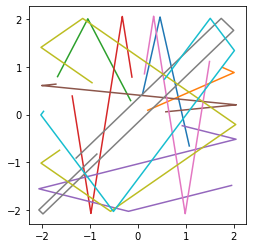

In [21]:
def evolve(ts, balls, boundary, results):

    for i, t in enumerate(ts):
    
        if i == 0:
        
            results[:,i,:] = balls.pos
        
        else:
        
            dt = t - ts[i-1]
        
            balls.move(dt)
            
            balls.collide(boundary)
        
            results[:,i,:] = balls.pos
            
    return results

def plot_results(results):
    
    numbers = len(results)
    
    for n in range(numbers):
    
        plt.plot(results[n,:,0], results[n,:,1])
        plt.axis('square')
    
    return

numbers  = 10              # particle numbers
balls    = Balls(numbers)  # balls
boundary = 2               # boundary

N  = 100                  # time seperation numbers
T  = 10                   # total time
ts = np.linspace(0, T, N) # every time


results = np.zeros(shape=(numbers, N, 2)) # result about balls' position
results = evolve(ts, balls, boundary, results)
plot_results(results)